In [1]:
! ls ../nuclei/data_nuclei/cluster\ nuclei/label/ | head

cluster1(label).bmp
cluster10(label).bmp
cluster11(label).bmp
cluster12(label).bmp
cluster13(label).bmp
cluster14(label).bmp
cluster15(label).bmp
cluster16(label).bmp
cluster17(label).bmp
cluster18(label).bmp


In [2]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import glob
import shutil
import os
import random


Using TensorFlow backend.


In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers import Reshape, Permute, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, concatenate, Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger, LambdaCallback
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping,TensorBoard


In [4]:
base_path = "../nuclei/data_nuclei/cluster nuclei/"
base_label_path = base_path + "label/"
base_image_path = base_path + "original/"
base_mask_path = base_path + "masks/"

In [60]:
! mkdir ../nuclei/data_nuclei/cluster\ nuclei/masks 

mkdir: ../nuclei/data_nuclei/cluster nuclei/masks: File exists


In [5]:
image_paths = glob.glob(base_image_path+"*")

In [136]:
for image_path in image_paths:
    image_name = image_path.split('/')[-1].split('.')[0]

    label_path = base_label_path+image_name+'(label).bmp'

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

#     plt.imshow(image)
#     plt.show()
#     plt.imshow(label)
#     plt.show()

    mask = label-image
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

#     plt.imshow(mask)
#     plt.show()

    mask = (mask>0)*1
    _, cnts, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_mask = np.zeros(mask.shape)

    cv2.drawContours(new_mask, cnts, -1, 255, -1)
    cv2.imwrite(base_mask_path + image_name + ".bmp", new_mask)
#     plt.imshow(new_mask)
#     plt.show()



In [7]:
# for image_path in image_paths:
#     image_name = image_path.split('/')[-1].split('.')[0]

#     label_path = base_label_path+image_name+'(label).bmp'
    
#     image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#     label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
#     mask = cv2.cvtColor(cv2.imread(base_mask_path + image_name + ".bmp"), cv2.COLOR_BGR2RGB)
    
#     plt.figure(figsize=(20,60))
#     plt.subplot(131)
#     plt.imshow(image)
#     plt.subplot(132)
#     plt.imshow(label)
#     plt.subplot(133)
#     plt.imshow(mask)
#     plt.show()

In [150]:
print len(image_paths)


52


In [151]:
! mkdir ../nuclei/data_nuclei/train/image
! mkdir ../nuclei/data_nuclei/train/mask
! mkdir ../nuclei/data_nuclei/test/image
! mkdir ../nuclei/data_nuclei/test/mask
! mkdir ../nuclei/data_nuclei/valid/image
! mkdir ../nuclei/data_nuclei/valid/mask


In [153]:
! mkdir ../nuclei/data_nuclei/train/image/images
! mkdir ../nuclei/data_nuclei/train/mask/images
! mkdir ../nuclei/data_nuclei/test/image/images
! mkdir ../nuclei/data_nuclei/test/mask/images
! mkdir ../nuclei/data_nuclei/valid/image/images
! mkdir ../nuclei/data_nuclei/valid/mask/images


In [142]:
# ! rm ../nuclei/data_nuclei/train/image/*
# ! rm ../nuclei/data_nuclei/train/mask/*
# ! rm ../nuclei/data_nuclei/test/image/*
# ! rm ../nuclei/data_nuclei/test/mask/*
# ! rm ../nuclei/data_nuclei/valid/image/*
# ! rm ../nuclei/data_nuclei/valid/mask/*


rm: ../nuclei/data_nuclei/train/image/images: is a directory
rm: ../nuclei/data_nuclei/train/mask/images: is a directory
rm: ../nuclei/data_nuclei/test/image/images: is a directory
rm: ../nuclei/data_nuclei/test/mask/images: is a directory
rm: ../nuclei/data_nuclei/valid/image/images: is a directory
rm: ../nuclei/data_nuclei/valid/mask/images: is a directory


In [152]:

random.shuffle(image_paths)


In [154]:
random_list = image_paths
for idx in xrange(len(random_list)):
    image_path = random_list[idx]
    image_name = image_path.split('/')[-1]
    mask_path = base_mask_path+image_name
    if idx<30:
        output_set = "train"
    elif idx<40:
        output_set = "valid"
    else:
        output_set = "test"

    dest_img_path = "../nuclei/data_nuclei/"+output_set+"/image/images/"+image_name
    dest_mask_path = "../nuclei/data_nuclei/"+output_set+"/mask/images/"+image_name
    
    shutil.copyfile(image_path, dest_img_path)
    shutil.copyfile(mask_path, dest_mask_path)


In [96]:
def get_unet_1class_small(img_rows=192, img_cols=192, l2_lambda=0.0):
    inputs = Input((img_rows, img_cols,3))
    conv1 = ZeroPadding2D((1,1))(inputs) 
    conv1 = Conv2D(32, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv1)
    conv1 = ZeroPadding2D((1,1))(conv1) 
    conv1 = Conv2D(32, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(conv1)

    conv2 = ZeroPadding2D((1,1))(pool1) 
    conv2 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv2)
    conv2 = ZeroPadding2D((1,1))(conv2) 
    conv2 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(conv2)

    conv3 = ZeroPadding2D((1,1))(pool2)
    conv3 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv3)
    conv3 = ZeroPadding2D((1,1))(conv3) 
    conv3 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(conv3)

    conv4 = ZeroPadding2D((1,1))(pool3) 
    conv4 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv4)
    conv4 = ZeroPadding2D((1,1))(conv4) 
    conv4 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),strides=(2,2))(conv4)

    conv5 = ZeroPadding2D((1,1))(pool4) 
    conv5 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv5)
    conv5 = ZeroPadding2D((1,1))(conv5) 
    conv5 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = ZeroPadding2D((1,1))(up6) 
    conv6 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv6)
    conv6 = ZeroPadding2D((1,1))(conv6) 
    conv6 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = ZeroPadding2D((1,1))(up7) 
    conv7 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv7)
    conv7 = ZeroPadding2D((1,1))(conv7) 
    conv7 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = ZeroPadding2D((1,1))(up8) 
    conv8 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv8)
    conv8 = ZeroPadding2D((1,1))(up8) 
    conv8 = Conv2D(64, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = ZeroPadding2D((1,1))(up9) 
    conv9 = Conv2D(32, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv9)
    conv9 = ZeroPadding2D((1,1))(conv9) 
    conv9 = Conv2D(32, 3, 3, activation='relu',kernel_regularizer=l2(l2_lambda))(conv9)

    out_logit = Conv2D(1, 1, 1, activation='relu')(conv9)
    out_pred = Activation('sigmoid', name = "prediction")(out_logit)


    model = Model(input=inputs, output=out_pred)

    return model

In [155]:
model = get_unet_1class_small()

/Users/shivam/work/venv/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  after removing the cwd from sys.path.
/Users/shivam/work/venv/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  
/Users/shivam/work/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
/Users/shivam/work/venv/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
/Users/shivam/work/venv/lib/python2.7

In [156]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 194, 194, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 192, 192, 32) 896         zero_padding2d_20[0][0]          
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 194, 194, 32) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [171]:
train_image_path = "../nuclei/data_nuclei/train/image"
train_mask_path = "../nuclei/data_nuclei/train/mask"
valid_image_path = "../nuclei/data_nuclei/valid/image"
valid_mask_path = "../nuclei/data_nuclei/valid/mask"
batch_size=1
train_samples = 30
validation_samples = 10

In [168]:
train_data_gen_args = dict(rescale=1./255,
                     horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=50,
                     #zoom_range=(0.8, 1.2),
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     fill_mode = 'constant',cval=0.0)

train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)
valid_image_datagen = ImageDataGenerator(**train_data_gen_args)
valid_mask_datagen = ImageDataGenerator(**train_data_gen_args)


seed1 = 1

train_image_generator = train_image_datagen.flow_from_directory(
                            train_image_path, 
                            target_size=(192, 192),
                            batch_size=batch_size, 
                            shuffle=False, 
                            color_mode='rgb',
                            class_mode=None,
                            seed=seed1)
train_mask_generator = train_mask_datagen.flow_from_directory(
                            train_mask_path, 
                            target_size=(192, 192),
                            batch_size=batch_size, 
                            shuffle=False,
                            color_mode='grayscale', 
                            class_mode=None,
                            seed=seed1)

valid_image_generator = valid_image_datagen.flow_from_directory(
                            valid_image_path, 
                            target_size=(192, 192),
                            batch_size=batch_size, 
                            shuffle=False, 
                            color_mode='rgb',
                            class_mode=None,
                            seed=seed1)
valid_mask_generator = valid_mask_datagen.flow_from_directory(
                            valid_mask_path, 
                            target_size=(192, 192),
                            batch_size=batch_size, 
                            shuffle=False,
                            color_mode='grayscale', 
                            class_mode=None,
                            seed=seed1)



Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [166]:
! ls ../nuclei/data_nuclei/test/mask/images/ | wc -l


      12


In [169]:
def threshold_mask(X_batch):
    samples = X_batch.shape[0]
    X_batch_new = np.zeros((X_batch.shape[0], X_batch.shape[1], X_batch.shape[2], 1), dtype=np.float64)

    for i in xrange(samples):
        temp = X_batch[i]
        temp[temp <= 0.5] = 0.0
        temp[temp > 0.5] = 1.0
        X_batch_new[i] = temp

    return X_batch_new

def combine_generator(gen1, gen2):
    while True:
        yield (gen1.next(), threshold_mask(gen2.next()))
train_generator = combine_generator(train_image_generator, train_mask_generator)
valid_generator = combine_generator(valid_image_generator, valid_mask_generator)

for X_batch, Y_batch in train_generator:
    print "Checking the input and output shape of train generator:"
    print X_batch.shape, Y_batch.shape
    print np.min(Y_batch[0]), np.min(Y_batch)
    print np.max(Y_batch[0]), np.max(Y_batch)
    print np.mean(X_batch), np.max(X_batch), np.min(X_batch)
    break

Checking the input and output shape of train generator:
(1, 192, 192, 3) (1, 192, 192, 1)
0.0 0.0
1.0 1.0
0.60733104 0.9915354 0.0


In [170]:
plot_model(model, to_file='model.pdf', show_shapes=True)

In [173]:
def dice(y_true, y_pred):
        eps = 0.00001 
        y_true_f = tf.reshape(y_true,[tf.shape(y_true)[0],tf.shape(y_true)[1]*tf.shape(y_true)[2],tf.shape(y_true)[3]])
        y_pred_f = tf.reshape(y_pred,[tf.shape(y_pred)[0],tf.shape(y_pred)[1]*tf.shape(y_pred)[2],tf.shape(y_pred)[3]])                                                                                                
        intersection = eps + 2*tf.reduce_sum(y_true_f*y_pred_f, axis=1)                                                    
        # eps added in denomintor, to take care for DivisionByZero error.
        union = eps + tf.reduce_sum(y_true_f*y_true_f, axis=1) + tf.reduce_sum(y_pred_f*y_pred_f, axis=1)                                    
        IOU = tf.div(intersection,union)                                                                               
        return (tf.reduce_mean(IOU))
         
def dice_loss(y_true, y_pred):
        return -dice(y_true, y_pred)

def dice_metric(y_true, y_pred):
        y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
        y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
        
        return dice(y_true_f, y_pred_f)

def iou_metric(y_true, y_pred):
        y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
        y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
        eps = 0.00001 
        y_true_f1 = tf.reshape(y_true_f,[tf.shape(y_true_f)[0],tf.shape(y_true_f)[1]*tf.shape(y_true_f)[2],tf.shape(y_true_f)[3]])
        y_pred_f1 = tf.reshape(y_pred_f,[tf.shape(y_pred_f)[0],tf.shape(y_pred_f)[1]*tf.shape(y_pred_f)[2],tf.shape(y_pred_f)[3]])                                                                                                
        intersection = eps + tf.reduce_sum(y_true_f1*y_pred_f1, axis=1)                                                    
        union = 2*eps + tf.reduce_sum(y_true_f1, axis=1) + tf.reduce_sum(y_pred_f1, axis=1) - intersection
        IOU = tf.div(intersection,union)

        return (tf.reduce_mean(IOU))

In [174]:
model.compile(optimizer=Adam(lr=1e-3),
              loss=dice_loss,
              metrics=[dice_metric, iou_metric])

In [175]:
model.fit_generator(train_generator,
		steps_per_epoch= train_samples // batch_size,
		epochs=10,
		validation_data= valid_generator,
		validation_steps= validation_samples // batch_size, verbose = 1)

Epoch 1/10
30/30 [==============================] - 27s 883ms/step - loss: -0.6498 - dice_metric: 0.5205 - iou_metric: 0.3872 - val_loss: -0.6239 - val_dice_metric: 0.0270 - val_iou_metric: 0.0139
Epoch 2/10
30/30 [==============================] - 20s 675ms/step - loss: -0.6949 - dice_metric: 0.4882 - iou_metric: 0.4011 - val_loss: -0.6594 - val_dice_metric: 0.3205 - val_iou_metric: 0.2179
Epoch 3/10
30/30 [==============================] - 19s 641ms/step - loss: -0.7557 - dice_metric: 0.7925 - iou_metric: 0.6712 - val_loss: -0.7641 - val_dice_metric: 0.8226 - val_iou_metric: 0.7024
Epoch 4/10
30/30 [==============================] - 19s 648ms/step - loss: -0.7830 - dice_metric: 0.8537 - iou_metric: 0.7470 - val_loss: -0.7925 - val_dice_metric: 0.8795 - val_iou_metric: 0.7853
Epoch 5/10
30/30 [==============================] - 20s 676ms/step - loss: -0.7801 - dice_metric: 0.8526 - iou_metric: 0.7470 - val_loss: -0.7816 - val_dice_metric: 0.8739 - val_iou_metric: 0.7769
Epoch 6/10
30/3

In [197]:
model.save('model.h5')

In [199]:
model

NameError: name 'model' is not defined

In [177]:
test_image_path = "../nuclei/data_nuclei/test/image"
test_mask_path = "../nuclei/data_nuclei/test/mask"

cluster49 Dice Metric: 0.8393044471740723 IOU Metric: 0.7231047749519348


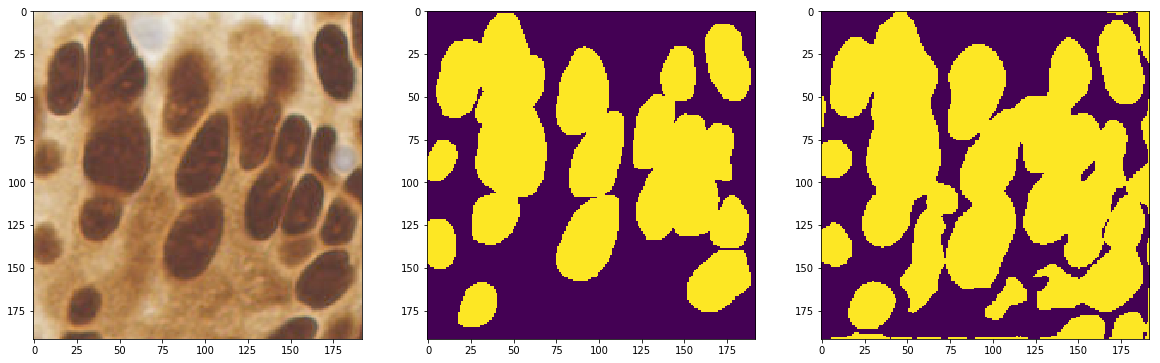

cluster5 Dice Metric: 0.8864173293113708 IOU Metric: 0.7960049510002136


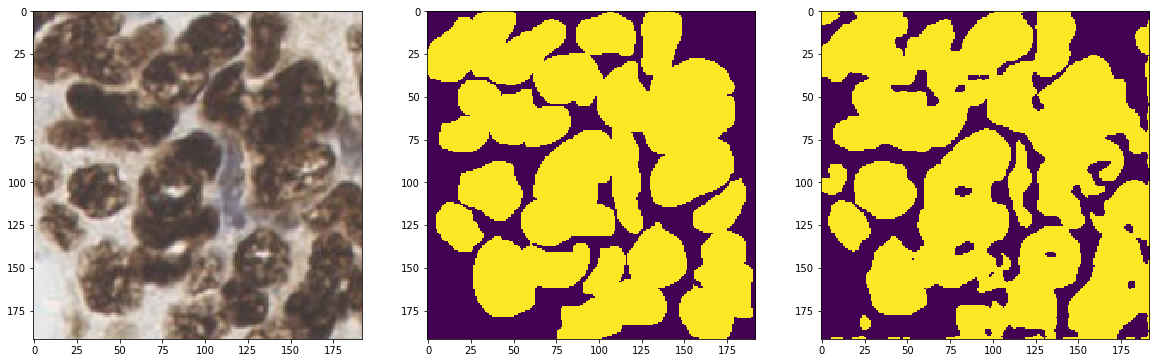

cluster28 Dice Metric: 0.8127071261405945 IOU Metric: 0.6845043897628784


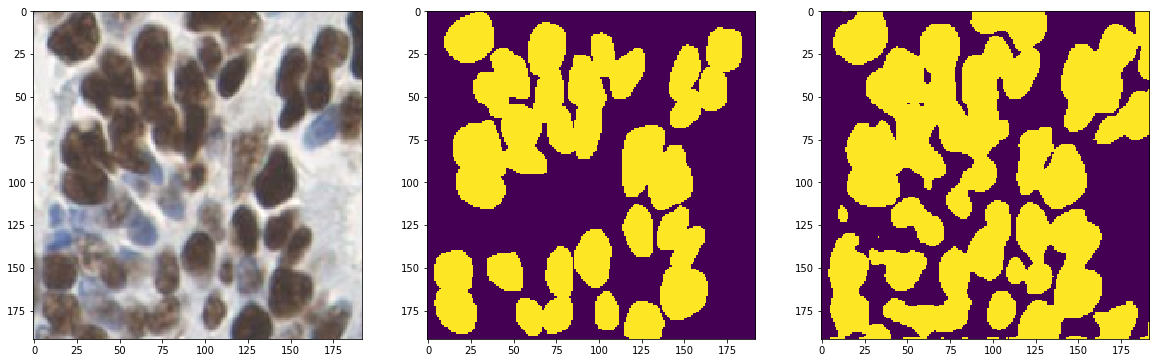

cluster39 Dice Metric: 0.8170260787010193 IOU Metric: 0.6906543970108032


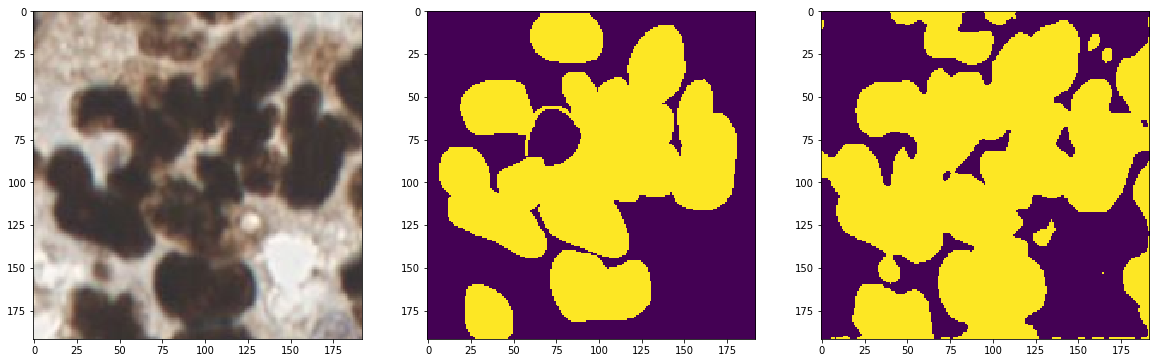

cluster36 Dice Metric: 0.8417270183563232 IOU Metric: 0.7267086505889893


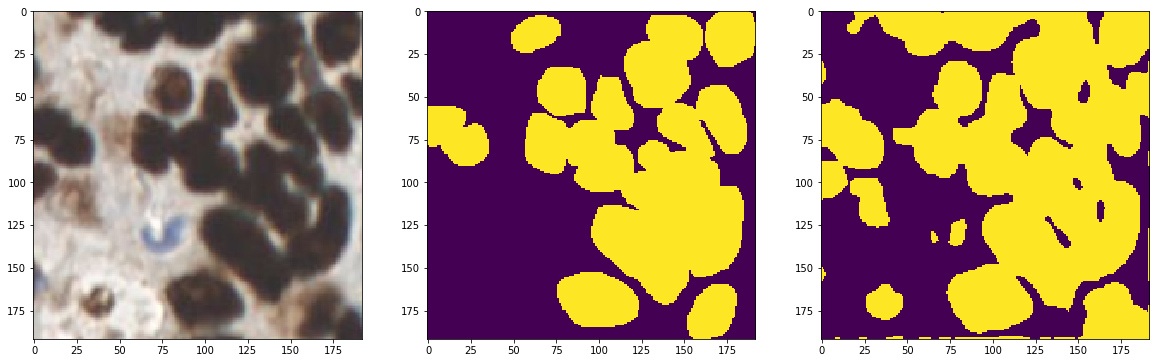

cluster19 Dice Metric: 0.8417364358901978 IOU Metric: 0.7267227172851562


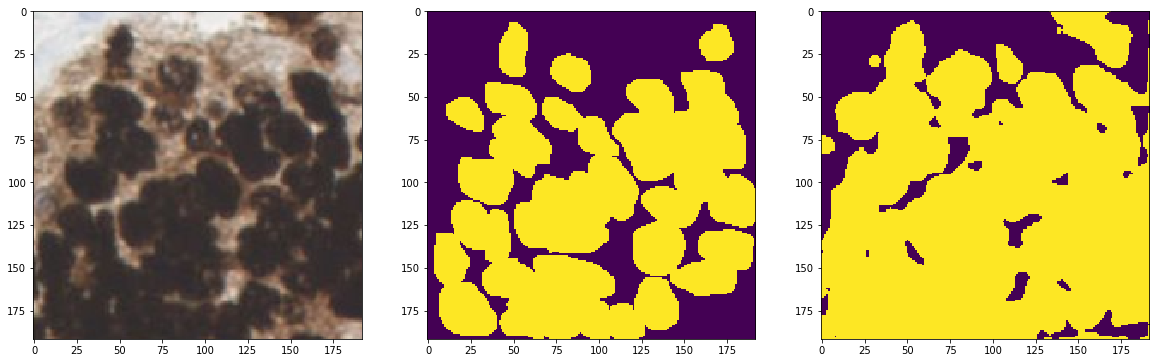

cluster30 Dice Metric: 0.8531402945518494 IOU Metric: 0.7438924312591553


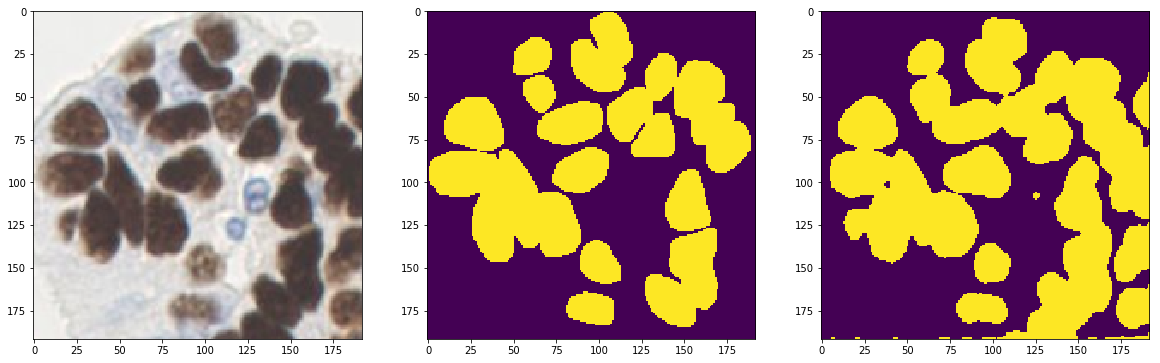

cluster24 Dice Metric: 0.850736141204834 IOU Metric: 0.7402443885803223


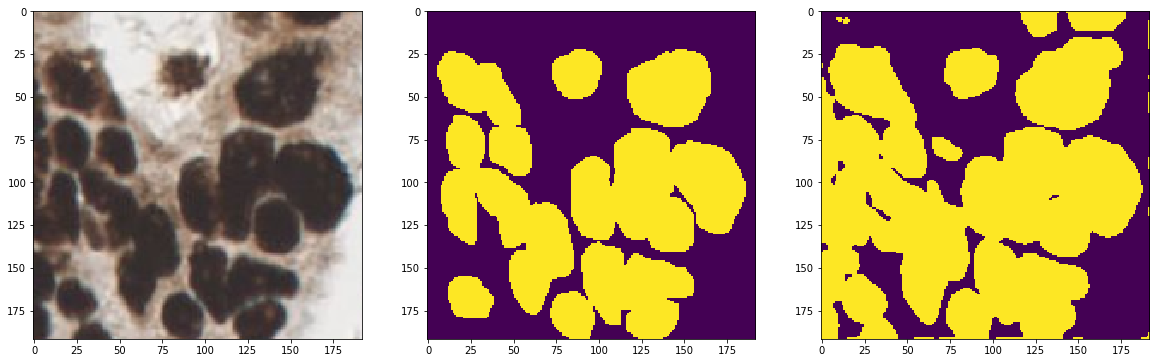

cluster26 Dice Metric: 0.8076516389846802 IOU Metric: 0.6773620843887329


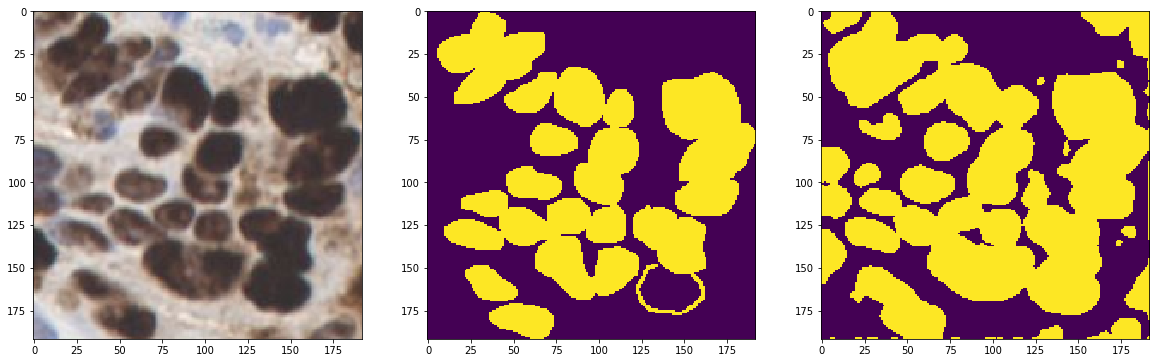

cluster40 Dice Metric: 0.8763685822486877 IOU Metric: 0.7799431085586548


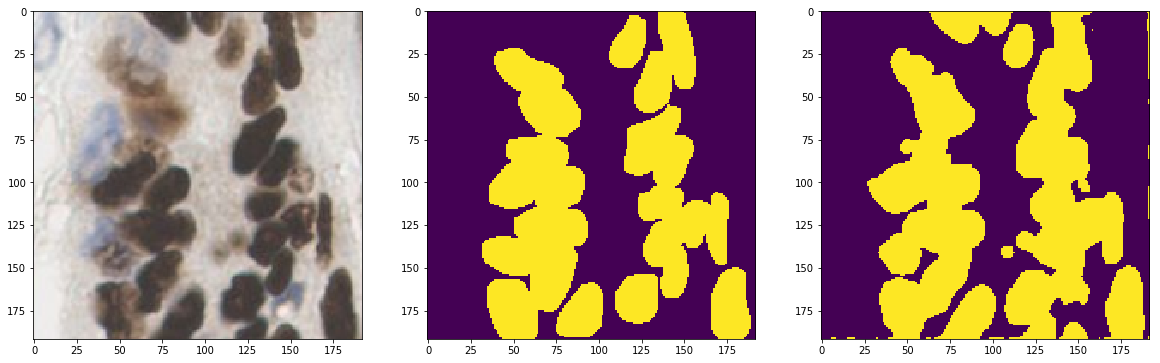

cluster52 Dice Metric: 0.8020133972167969 IOU Metric: 0.6694678068161011


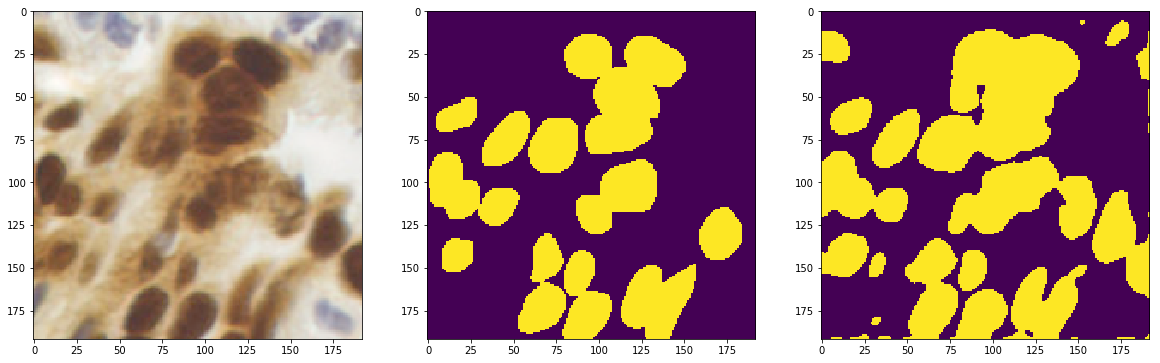

cluster9 Dice Metric: 0.8392489552497864 IOU Metric: 0.7230223417282104


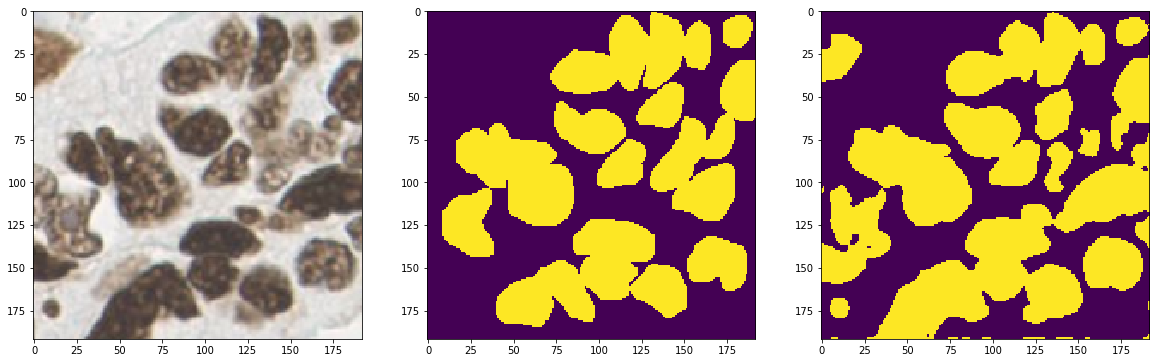

In [196]:
for path in glob.glob(test_image_path+"/images/*"):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    msk = cv2.cvtColor(cv2.imread(path.replace('image/','mask/')), cv2.COLOR_BGR2GRAY)
    
    img = cv2.resize(img, (192,192))
    msk = cv2.resize(msk, (192,192))
    img = np.reshape(img, (1,192,192,3))
    msk = np.reshape(msk, (1,192,192,1))
    img = img/255.0
    msk = msk/255.0
    
    msk = (msk>0.5)*1.0
    
    pred = model.predict(img, batch_size=None)
    err = model.evaluate(img, msk, batch_size=None, verbose=0)
    print  path.split('/')[-1].split('.')[0], "Dice Metric:", err[1], "IOU Metric:", err[2]
    pred = (pred>0.5)*1.0
    plt.figure(figsize=(20,60))
    plt.subplot(131)
    plt.imshow(img[0,:,:,:])
    plt.subplot(132)
    plt.imshow(msk[0,:,:,0])
    plt.subplot(133)
    plt.imshow(pred[0,:,:,0])
    plt.show()
    
    
    